- 보충자료 다운로드 
- 압축풀고 폴더 구글 드라이브 업로드
- 새로운 파일

##  구글 드라이브 연동

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## 라이브러리 불러오기

In [2]:
import pandas as pd                  # 데이터프레임 가공
import numpy as np                   # 수치 연산
import matplotlib                    # 시각화
import matplotlib.pyplot as plt
import statsmodels                   # 통계 관련
import scipy                         # 수학 과학 연산 
import seaborn as sns                # 시각화

print(pd.__version__)
print(np.__version__)
print(matplotlib.__version__)
print(statsmodels.__version__)
print(scipy.__version__)
print(sns.__version__)

1.3.5
1.21.6
3.2.2
0.10.2
1.4.1
0.11.2


## 데이터 불러오기
- pandas 옵션

In [3]:
pd.set_option('display.width', 80)
pd.set_option('display.max_columns', 7)
pd.set_option('display.max_rows', 20)
pd.options.display.float_format = '{:,.0f}'.format

In [4]:
DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/2022/Python 데이터 분석 라이브러리_20220423/Basic/Chapter 5. Missing Values & Outliers/data/'
covidtotals = pd.read_csv(DATA_PATH + "covidtotalswithmissings.csv")
covidtotals.head()

,iso_code,lastdate,location,...,median_age,gdp_per_capita,hosp_beds
0,AFG,2020-06-01,Afghanistan,...,19,"1,804",0
1,ALB,2020-06-01,Albania,...,38,"11,803",3
2,DZA,2020-06-01,Algeria,...,29,"13,914",2
3,AND,2020-06-01,Andorra,...,NaN,NaN,NaN
4,AGO,2020-06-01,Angola,...,17,"5,819",NaN


In [5]:
covidtotals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   iso_code         210 non-null    object 
 1   lastdate         210 non-null    object 
 2   location         210 non-null    object 
 3   total_cases      210 non-null    int64  
 4   total_deaths     210 non-null    int64  
 5   total_cases_pm   209 non-null    float64
 6   total_deaths_pm  209 non-null    float64
 7   population       210 non-null    float64
 8   pop_density      198 non-null    float64
 9   median_age       186 non-null    float64
 10  gdp_per_capita   182 non-null    float64
 11  hosp_beds        164 non-null    float64
dtypes: float64(7), int64(2), object(3)
memory usage: 19.8+ KB


- 이번 시간 목표
  + 결측치 처리
  + 이상값 식별 (IQR, 회귀를 이용한 이상값 식별)

In [6]:
covidtotals.set_index("iso_code", inplace = True)
covidtotals.head()

,lastdate,location,total_cases,...,median_age,gdp_per_capita,hosp_beds
iso_code,,,,,,,
AFG,2020-06-01,Afghanistan,15205,...,19,"1,804",0
ALB,2020-06-01,Albania,1137,...,38,"11,803",3
DZA,2020-06-01,Algeria,9394,...,29,"13,914",2
AND,2020-06-01,Andorra,764,...,NaN,NaN,NaN
AGO,2020-06-01,Angola,86,...,17,"5,819",NaN


- 사례 열(totvars)과 인구통계 열(demovars)을 만든다. 

In [7]:
totvars = ['location','total_cases','total_deaths','total_cases_pm', 'total_deaths_pm']
demovars = ['population','pop_density','median_age','gdp_per_capita', 'hosp_beds']

## 결측치 처리

In [8]:
covidtotals[demovars].isnull().sum(axis = 0)

population         0
pop_density       12
median_age        24
gdp_per_capita    28
hosp_beds         46
dtype: int64

In [9]:
demovarsmisscnt = covidtotals[demovars].isnull().sum(axis = 1)
demovarsmisscnt.value_counts()

0    156
1     24
2     12
3     10
4      8
dtype: int64

### Index Alignment
- 각 행에 인구통계 데이터가 세 가지 이상 누락된 국가를 나열해라. 
- 인덱스의 값끼리 연산이 이루어지는 것을 말함

In [12]:
s1 = pd.Series([1, 2, 3, 4], index = ['a', 'b', 'c', 'd'])
s2 = pd.Series([4, 3, 2, 1], index = ['d', 'c', 'b', 'a'])
s1 + s2

a    2
b    4
c    6
d    8
dtype: int64

In [15]:
covidtotals.loc[demovarsmisscnt >= 3, ['location'] + demovars].T

iso_code,AND,AIA,BES,...,TCA,VAT,ESH
location,Andorra,Anguilla,Bonaire Sint Eustatius and Saba,...,Turks and Caicos Islands,Vatican,Western Sahara
population,"77,265","15,002","26,221",...,"38,718",809,"597,330"
pop_density,164,NaN,NaN,...,37,NaN,NaN
median_age,NaN,NaN,NaN,...,NaN,NaN,28
gdp_per_capita,NaN,NaN,NaN,...,NaN,NaN,NaN
hosp_beds,NaN,NaN,NaN,...,NaN,NaN,NaN


- 코로나 관련 데이터에서 결측치 확인

In [16]:
covidtotals[totvars].isnull().sum(axis = 0)

location           0
total_cases        0
total_deaths       0
total_cases_pm     1
total_deaths_pm    1
dtype: int64

In [19]:
totvarsmisscnt = covidtotals[totvars].isnull().sum(axis = 1)
print(totvarsmisscnt.value_counts())
covidtotals.loc[totvarsmisscnt > 0].T

0    209
2      1
dtype: int64


iso_code,HKG
lastdate,2020-05-26
location,Hong Kong
total_cases,0
total_deaths,0
total_cases_pm,NaN
total_deaths_pm,NaN
population,"7,496,988"
pop_density,"7,040"
median_age,45
gdp_per_capita,"56,055"


- fillna() : 누락값 채우는 메서드

In [21]:
covidtotals['total_cases_pm'].fillna(0, inplace = True)
covidtotals['total_deaths_pm'].fillna(0, inplace = True)

In [23]:
covidtotals[totvars].isnull().sum(axis = 0)

location           0
total_cases        0
total_deaths       0
total_cases_pm     0
total_deaths_pm    0
dtype: int64

# 1개 변수에서 이상값 식별하기
- 이상값의 정의 
  + 도메인 내에서 정의 / 제조업 / 금융업 / 유통업
  + IQR 기법 1

## 라이브러리 불러오기

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqline
import scipy.stats as scistat

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


- 데이터 불러오기

In [26]:
covidtotals = pd.read_csv(DATA_PATH + 'covidtotals.csv')
covidtotals.set_index('iso_code', inplace = True)

In [27]:
covidtotals.head()

,lastdate,location,total_cases,...,median_age,gdp_per_capita,hosp_beds
iso_code,,,,,,,
AFG,2020-06-01,Afghanistan,15205,...,19,"1,804",0
ALB,2020-06-01,Albania,1137,...,38,"11,803",3
DZA,2020-06-01,Algeria,9394,...,29,"13,914",2
AND,2020-06-01,Andorra,764,...,NaN,NaN,NaN
AGO,2020-06-01,Angola,86,...,17,"5,819",NaN


In [28]:
totvars = ['location','total_cases','total_deaths','total_cases_pm', 'total_deaths_pm']
demovars = ['population','pop_density','median_age','gdp_per_capita', 'hosp_beds']

- 코로나 19 사례 데이터에 대한 기술 통계량
- 왜도, 첨도

In [29]:
covidtotalsonly = covidtotals.loc[:, totvars]
covidtotalsonly.describe()

,total_cases,total_deaths,total_cases_pm,total_deaths_pm
count,210,210,210,210
mean,"29,216","1,771","1,355",56
std,"136,398","8,706","2,625",145
min,0,0,0,0
25%,176,4,93,1
50%,"1,242",26,281,6
75%,"10,117",241,"1,801",32
max,"1,790,191","104,383","19,771","1,238"


- 수치 데이터를 10분위수로 분류함

In [31]:
pd.options.display.float_format = '{:,.2f}'.format
covidtotalsonly.quantile(np.arange(0.0, 1.1, 0.1))

,total_cases,total_deaths,total_cases_pm,total_deaths_pm
0.00,0.00,0.00,0.00,0.00
0.10,22.90,0.00,18.00,0.00
0.20,105.20,2.00,56.29,0.38
0.30,302.00,6.70,115.43,1.72
0.40,762.00,12.00,213.97,3.96
0.50,"1,242.50",25.50,280.93,6.15
0.60,"2,514.60",54.60,543.96,12.25
0.70,"6,959.80",137.20,"1,071.24",25.95
0.80,"16,847.20",323.20,"2,206.30",49.97
0.90,"46,513.10","1,616.90","3,765.14",138.90


- 기초통계 : 모수검정, 회귀분석 등등
-            전제조건 : 데이터가 정규분포를 이루어야 함

In [32]:
covidtotalsonly.skew()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


total_cases       10.80
total_deaths       8.93
total_cases_pm     4.40
total_deaths_pm    4.67
dtype: float64

In [33]:
covidtotalsonly.kurtosis()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


total_cases       134.98
total_deaths       95.74
total_cases_pm     25.24
total_deaths_pm    27.24
dtype: float64

## 정규성 검정 테스트
- p값이 0.05 미만에서 95% 수준에서 정규분포의 귀무가설을 기각할 수 있다. 
- 샤피로 검정
  + 귀무가설 : 표본의 모집단이 정규분포를 따른다. (p > 0.05)
  + 대립가설 : 표본의 모집단이 정규분포를 따르지 않는다. (p < 0.05)


In [34]:
# test for normality
def testnorm(var, df):
  stat, p = scistat.shapiro(df[var])
  return p

- total_cases 데이터는 정규분포를 따르지 않는다.
--> 이상값이 존재한다. 

In [35]:
testnorm("total_cases", covidtotalsonly)

3.753789128593843e-29

-  QQLINE 그래프

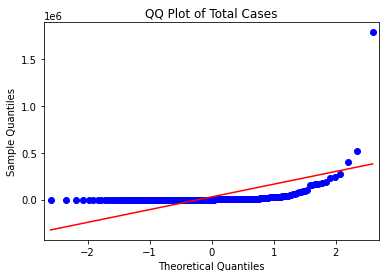

In [36]:
sm.qqplot(covidtotalsonly[['total_cases']]. \
  sort_values(['total_cases']), line='s')
plt.title("QQ Plot of Total Cases")
plt.show()

- 많은 사례들이 0에 근접함. 일부 정규분포에서 크게 벗어난 것 확인

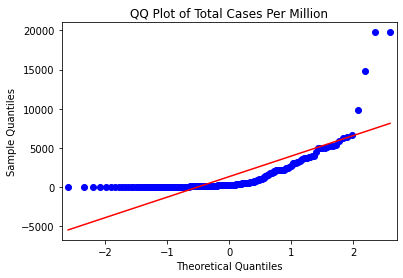

In [37]:
sm.qqplot(covidtotals[['total_cases_pm']]. \
  sort_values(['total_cases_pm']), line='s')
plt.title("QQ Plot of Total Cases Per Million")
plt.show()

- 거리 = 제 3사분위 - 제 1사분위
  + 이상값 간주 : 거리 * 1.5 (+/-)
- 확진자수 음수 존재 (X)

In [38]:
# show outliers for total cases
thirdq, firstq = covidtotalsonly.total_cases.quantile(0.75), covidtotalsonly.total_cases.quantile(0.25)
interquartilerange = 1.5*(thirdq-firstq)
outlierhigh, outlierlow = interquartilerange+thirdq, firstq-interquartilerange
print(outlierlow, outlierhigh, sep=" <--> ")

-14736.125 <--> 25028.875


- 이상치 판별 함수 만들기

In [39]:
# generate a table of outliers and save it to Excel
def getoutliers():
  dfout = pd.DataFrame(columns=covidtotals.columns, data=None)
  for col in covidtotalsonly.columns[1:]:

    # 3사분위, 1사분위
    thirdq, firstq = covidtotalsonly[col].quantile(0.75), covidtotalsonly[col].quantile(0.25)

    # 3사분위 - 1사분위
    interquartilerange = 1.5*(thirdq-firstq)

    # 이상치의 상한 및 하한 경계값 정하기
    outlierhigh, outlierlow = interquartilerange+thirdq, firstq-interquartilerange

    # 각 데이터 추출
    df = covidtotals.loc[(covidtotals[col]>outlierhigh) | (covidtotals[col]<outlierlow)]

    # 임계치 수준에 검사한 변수를 가리키는 열(varname 추가)
    df = df.assign(varname = col, threshlow = outlierlow, threshhigh = outlierhigh)
    dfout = pd.concat([dfout, df])
  return dfout

outliers = getoutliers()
outliers['varname'].value_counts()
# outliers.to_excel("views/outlierscases.xlsx")

total_deaths       36
total_cases        33
total_deaths_pm    28
total_cases_pm     17
Name: varname, dtype: int64

In [40]:
outliers

,lastdate,location,total_cases,...,varname,threshlow,threshhigh
BGD,2020-06-01,Bangladesh,47153,...,total_cases,"-14,736.12","25,028.88"
BLR,2020-06-01,Belarus,42556,...,total_cases,"-14,736.12","25,028.88"
BEL,2020-06-01,Belgium,58381,...,total_cases,"-14,736.12","25,028.88"
BRA,2020-06-01,Brazil,514849,...,total_cases,"-14,736.12","25,028.88"
CAN,2020-06-01,Canada,90936,...,total_cases,"-14,736.12","25,028.88"
...,...,...,...,...,...,...,...
ESP,2020-05-31,Spain,239429,...,total_deaths_pm,-45.45,78.12
SWE,2020-06-01,Sweden,37542,...,total_deaths_pm,-45.45,78.12
CHE,2020-06-01,Switzerland,30779,...,total_deaths_pm,-45.45,78.12
GBR,2020-06-01,United Kingdom,274762,...,total_deaths_pm,-45.45,78.12


- 백만명당 확진자 수의 이상값 살펴보기

In [43]:
outliers.loc[outliers.varname == "total_cases_pm", ['location', 'total_cases_pm', 'pop_density', 'gdp_per_capita']].sort_values(['total_cases_pm'], ascending = False)

,location,total_cases_pm,pop_density,gdp_per_capita
SMR,San Marino,"19,771.35",556.67,"56,861.47"
QAT,Qatar,"19,753.15",227.32,"116,935.60"
VAT,Vatican,"14,833.13",NaN,NaN
AND,Andorra,"9,888.05",163.75,NaN
BHR,Bahrain,"6,698.47","1,935.91","43,290.71"
LUX,Luxembourg,"6,418.78",231.45,"94,277.96"
KWT,Kuwait,"6,332.42",232.13,"65,530.54"
SGP,Singapore,"5,962.73","7,915.73","85,535.38"
USA,United States,"5,408.39",35.61,"54,225.45"
ISL,Iceland,"5,292.31",3.40,"46,482.96"


# 회귀를 이용한 이상값 식별하기
- 데이터를 불러오기

In [44]:
covidtotals.head()

,lastdate,location,total_cases,...,median_age,gdp_per_capita,hosp_beds
iso_code,,,,,,,
AFG,2020-06-01,Afghanistan,15205,...,18.60,"1,803.99",0.50
ALB,2020-06-01,Albania,1137,...,38.00,"11,803.43",2.89
DZA,2020-06-01,Algeria,9394,...,29.10,"13,913.84",1.90
AND,2020-06-01,Andorra,764,...,NaN,NaN,NaN
AGO,2020-06-01,Angola,86,...,16.80,"5,819.49",NaN


In [45]:
totvars = ['location','total_cases','total_deaths','total_cases_pm', 'total_deaths_pm']
demovars = ['population','pop_density','median_age','gdp_per_capita', 'hosp_beds']

- 전체 확진자 수, 사망자 수 및 인구통계 열에 상관관계표를 생성

In [46]:
covidtotals.corr(method='pearson')

,total_cases,total_deaths,total_cases_pm,...,median_age,gdp_per_capita,hosp_beds
total_cases,1.00,0.93,0.18,...,0.16,0.19,0.03
total_deaths,0.93,1.00,0.18,...,0.21,0.20,0.02
total_cases_pm,0.18,0.18,1.00,...,0.31,0.65,0.08
total_deaths_pm,0.25,0.39,0.59,...,0.39,0.38,0.12
population,0.27,0.21,-0.06,...,0.02,-0.06,-0.04
pop_density,-0.03,-0.03,0.11,...,0.18,0.32,0.31
median_age,0.16,0.21,0.31,...,1.00,0.65,0.66
gdp_per_capita,0.19,0.20,0.65,...,0.65,1.00,0.30
hosp_beds,0.03,0.02,0.08,...,0.66,0.30,1.00


- 총 확진자 수에 비해 총 사망자 수가 예상을 벗어나는 국가가 있는지 확인 
- 일반적인 관점 : 총 확진자 수 많음 --> 총 사망자 수 많음
- (1) 총 확진자 수 다수 --> 총 사망자 수 작음 (방역 성공)
- (2) 총 확진자 수 적음 --> 총 사망자 수 많음 (방역 실패)

- qcut
--> 수치 데이터로 표시는 됨, 수치가 아님
--> High Cardinality
수치 : 1, 2, 3     --> 범주화 작업
      95%, 4%, 1%

In [47]:
covidtotalsonly = covidtotals.loc[:, totvars]
covidtotalsonly['total_cases_q'] = pd.qcut(covidtotalsonly['total_cases'], 
                                           labels=['very low','low','medium','high','very high'], 
                                           q=5, 
                                           precision=0)
covidtotalsonly['total_deaths_q'] = pd.qcut(covidtotalsonly['total_deaths'], 
                                            labels=['very low','low','medium','high','very high'], 
                                            q=5, 
                                            precision=0)

pd.crosstab(covidtotalsonly.total_cases_q, covidtotalsonly.total_deaths_q)

total_deaths_q,very low,low,medium,high,very high
total_cases_q,,,,,
very low,34,7,1,0,0
low,12,19,10,1,0
medium,1,13,15,13,0
high,0,0,12,24,6
very high,0,0,2,4,36


In [48]:
covidtotals.loc[(covidtotalsonly.total_cases_q=="very high") & (covidtotalsonly.total_deaths_q=="medium")].T

iso_code,QAT,SGP
lastdate,2020-06-01,2020-06-01
location,Qatar,Singapore
total_cases,56910,34884
total_deaths,38,23
total_cases_pm,"19,753.15","5,962.73"
total_deaths_pm,13.19,3.93
population,"2,881,060.00","5,850,343.00"
pop_density,227.32,"7,915.73"
median_age,31.90,42.40
gdp_per_capita,"116,935.60","85,535.38"


In [49]:
covidtotals.loc[(covidtotalsonly.total_cases_q=="low") & (covidtotalsonly.total_deaths_q=="high")].T

iso_code,YEM
lastdate,2020-06-01
location,Yemen
total_cases,323
total_deaths,80
total_cases_pm,10.83
total_deaths_pm,2.68
population,"29,825,968.00"
pop_density,53.51
median_age,20.30
gdp_per_capita,"1,479.15"


In [51]:
covidtotals['hosp_beds'].mean()

3.012670731707318

- 총 확진자 수와 총 사망자 수의 산점도 작성

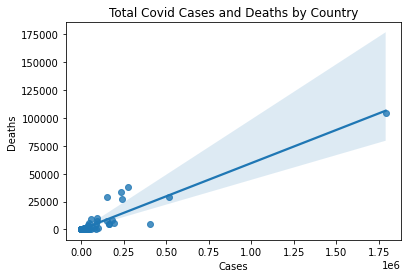

In [52]:
ax = sns.regplot(x="total_cases", y="total_deaths", data=covidtotals)
ax.set(xlabel="Cases", ylabel="Deaths", title="Total Covid Cases and Deaths by Country")
plt.show()

In [54]:
covidtotals.loc[(covidtotals.total_cases < 300000) & (covidtotals.total_deaths > 20000)].T

iso_code,FRA,ITA,ESP,GBR
lastdate,2020-06-01,2020-06-01,2020-05-31,2020-06-01
location,France,Italy,Spain,United Kingdom
total_cases,151753,233019,239429,274762
total_deaths,28802,33415,27127,38489
total_cases_pm,"2,324.88","3,853.99","5,120.95","4,047.40"
total_deaths_pm,441.25,552.66,580.20,566.97
population,"65,273,512.00","60,461,828.00","46,754,783.00","67,886,004.00"
pop_density,122.58,205.86,93.11,272.90
median_age,42.00,47.90,45.50,40.80
gdp_per_capita,"38,605.67","35,220.08","34,272.36","39,753.24"
